In [1]:
import pandas as pd
import numpy as np
from numpy import nanargmax
from numpy import argmax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
LogReg=LogisticRegression()
LinReg=LinearRegression()

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scikeras.wrappers import KerasClassifier

from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import janitor

import warnings
warnings.filterwarnings('ignore')

C:\Users\xysti\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\xysti\AppData\Local\Temp\ipykernel_3692\2751617237.py:43: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


#### Please go to File -> Trust Notebook, to see the graphs of the notebooks

#  1. DATA PREPARATION 

In [2]:
# IMPORT DATA
df = pd.read_excel('D:/Angelo/DTU/Thesis/Data/PMS_Data_SMC_IN.xlsx')

# CHECK COLUMNS DROP NOT NEEDED
df.columns
df = df.drop(columns=['TBO acc. MAN (hrs)', 'Manager', 'JOB_TITLE', 'Comment', 'NEXT_DUE_DATE', 'NEXT_DUE_HRS'])

# TRIM TEXT
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())



# Rename date column
df = df.rename(columns={"LAST_DONE_DATE": "Maintenance_Date", "LAST_DONE_HRS": "Running_Hours"})
df

,VESSEL_NAME,EQUIPMENT_NAME,EQUIPMENT_CODE,FREQUENCY,JOB_TYPE,Maintenance_Date,Running_Hours
0,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,8000,Overhaul,2020-12-11,68693.0
1,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,16000,Overhaul,2020-12-11,68693.0
2,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,4000,Inspection,2021-07-13,71960.0
3,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,4000,Inspection,2021-08-03,72037.0
4,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,16000,Overhaul,2020-10-27,67792.0
...,...,...,...,...,...,...,...
3378,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.2,601.01.02.02,12000,Overhaul,2021-02-27,20931.0
3379,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.3,601.01.02.03,12000,Overhaul,2019-02-21,15204.0
3380,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.4,601.01.02.04,12000,Overhaul,2018-07-09,13281.0
3381,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.5,601.01.02.05,12000,Overhaul,2020-07-31,19193.0


In [3]:
### 3. DROP NON-OVERHAULS AND DROP JOB COLUMN
df = (df[df['JOB_TYPE'] == 'Overhaul'] )
df = df.drop(columns=['JOB_TYPE'])

In [4]:
### 4. CREATE CONDITIONAL COLUMN (MAINTENANCE KIT) BASED ON EQUIPMENT CODE
# These are the  maintenance kits used in the corresponding jobs
df['Maintenance_Kit'] = pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.03."), "Piston Ring CR", 
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.02."), "Stuff. Box MK",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.01.01."), "Fuel Pump",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.10.01.01"), "Alpha Lub",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.04."), "Cyl. Liner",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.01"), "Cyl. Cover",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.12.01"), "Exh. Valve Act",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.01.02"), "Press. Booster",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.09.02."), "Fuel Valve",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.04."), "Accumulators ME",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.01."), "Prop. Valve",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.20.01.03."), "Hydr. Cyl. Unit",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("651."), "Auxiliary Engine MK",
                                    pd.np.where(df.EQUIPMENT_CODE.str.contains("601.01.15.01"), "Turbocharger",
                                    "N/A"))))))))))))))


In [5]:
df

,VESSEL_NAME,EQUIPMENT_NAME,EQUIPMENT_CODE,FREQUENCY,Maintenance_Date,Running_Hours,Maintenance_Kit
0,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,8000,2020-12-11,68693.0,Fuel Valve
1,Aqua Bonanza,ME FUEL INJECTOR NO.2B,601.01.09.02.02.02,16000,2020-12-11,68693.0,Fuel Valve
4,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,16000,2020-10-27,67792.0,Fuel Valve
5,Aqua Bonanza,ME FUEL INJECTOR NO.3B,601.01.09.02.03.02,8000,2020-10-27,67792.0,Fuel Valve
6,Aqua Bonanza,ME FUEL INJECTOR NO.4B,601.01.09.02.04.02,16000,2020-10-27,67792.0,Fuel Valve
...,...,...,...,...,...,...,...
3378,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.2,601.01.02.02,12000,2021-02-27,20931.0,Stuff. Box MK
3379,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.3,601.01.02.03,12000,2019-02-21,15204.0,Stuff. Box MK
3380,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.4,601.01.02.04,12000,2018-07-09,13281.0,Stuff. Box MK
3381,Zoe Schulte,ME PISTON ROD & STUFFING BOX NO.5,601.01.02.05,12000,2020-07-31,19193.0,Stuff. Box MK


In [6]:
### 5: CREATE CYLINDER NUMBER AND INJECTOR NUMBER COLUMN
# The column "EQUIPMENT_NAME" contains spaces sometimes after NO. - We remove those spaces
df['EQUIPMENT_NAME'] = df['EQUIPMENT_NAME'].str.replace('NO. ','NO.')

# Take the 2 numbers after NO.
df['TEMP_COL'] = df.EQUIPMENT_NAME.str.extract('\.(.{,2})') 
# split temporary column
df[['A', 'Cylinder_Number', 'Injector_Number', 'D']] = df['TEMP_COL'].str.split('',expand=True)
# Drop unwanted columns
df = df.drop(columns=['A', 'D', 'TEMP_COL'])

In [7]:
### 6. REMOVE ROWS THAT CONTAIN INDICATOR VALVE OR SAFETY VALVE (THEY ARE CONSIDERED OBSOLETE)   
df = df[df["EQUIPMENT_NAME"].str.contains("INDICATOR VALVE") == False]
df = df[df["EQUIPMENT_NAME"].str.contains("SAFETY VALVE") == False]

### 7. CREATE MAINTENANCE YEAR
df['maintainance_year'] = df['Maintenance_Date'].dt.year

### 8. REMOVE DUPLICATE ROWS
df = df.drop_duplicates(['VESSEL_NAME','Maintenance_Kit','Cylinder_Number', 'Injector_Number','maintainance_year', 'EQUIPMENT_CODE'], keep='last')

### 9. THERE ARE A FEW ROWS WITH NAN (4 rows) - WE REMOVE THEM 
df.isna().sum().sum()
df=df.dropna(axis=0)

In [8]:
### 10. WE WILL PREDICT EACH VALVE MAINTENANCE SEPARATELY
# ADD INJECTOR NUMBER TO MAINTENANCE KIT
df["Maintenance_Kit"] = df['Maintenance_Kit'].astype(str) +" "+ df["Injector_Number"]
# TRIM TEXT
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

### 11. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['EQUIPMENT_NAME', 'EQUIPMENT_CODE', 'Injector_Number'])

### 12. ADD OUTPUT COLUMN (INDICATES THAT A MAINTENANCE OCCURED)
df['done'] = 1

# 2. DATA ANALYSIS

<AxesSubplot:title={'center':'Count of jobs done per year'}, xlabel='Year', ylabel='Count'>

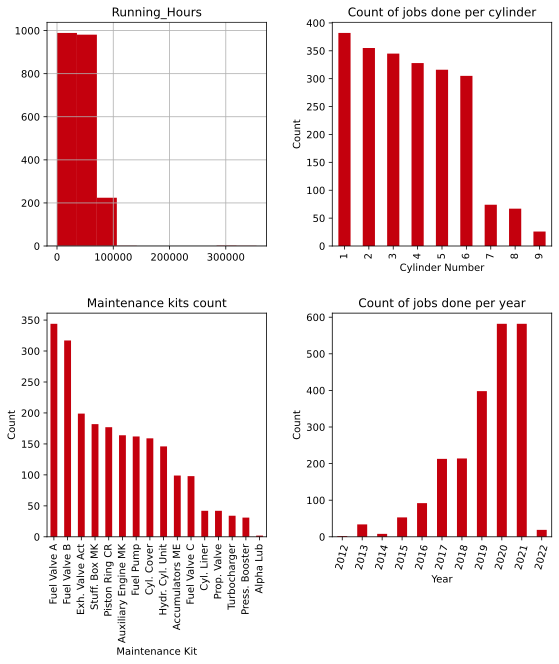

In [9]:
### 1. Initial visualization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2)

df.hist('Running_Hours', ax=axes[0,0],  color = [(0.77,0,0.05)])
#df['VESSEL_NAME'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[0,0])
df['Cylinder_Number'].value_counts(sort=True).loc[['1', '2', '3','4', '5', '6','7', '8', '9']].plot(kind='bar', title = 'Count of jobs done per cylinder', xlabel='Cylinder Number', ylabel='Count', rot=90, ax=axes[0,1], color = [(0.77,0,0.05)])
df['Maintenance_Kit'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[1,0],  color = [(0.77,0,0.05)])
df['maintainance_year'].value_counts(sort=False).loc[[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019, 2020, 2021,2022]].plot(kind='bar', title = 'Count of jobs done per year', xlabel='Year', ylabel='Count', rot=75, ax=axes[1,1],  color = [(0.77,0,0.05)])

In [10]:
### 2. DELETE MAINTENANCE FROM 2015 AND BEFORE (too few observations, if I keep them I will have ca.190000 rows)
df = df[df['maintainance_year'] > 2015]  

In [11]:
# 4. REMOVE ALPHA LUB FROM PREDICTION (THEY OCCUR TOO FEW (2) TIMES - WE WON'T PREDICT THIS TYPE)
#    REMOVE AUXILARY ENGINE KITS (THEY DON'T REFEER TO THE AMIN ENGINES)
df = df[df['Maintenance_Kit'] != 'Alpha Lub']
df = df[df['Maintenance_Kit'] != 'Auxiliary Engine MK']

frequency column is inconsistent, might cause problems to the models. Every overhaul should occur after specific hours

In [12]:
df_temp = df.groupby(["Maintenance_Kit", "FREQUENCY"]).size().reset_index(name='Count')

In [13]:
df_temp

,Maintenance_Kit,FREQUENCY,Count
0,Accumulators ME,32000,95
1,Cyl. Cover,12000,58
2,Cyl. Cover,16000,79
3,Cyl. Cover,24000,16
4,Cyl. Cover,96000,6
5,Cyl. Liner,16000,23
6,Cyl. Liner,24000,18
7,Exh. Valve Act,6000,12
8,Exh. Valve Act,8000,12
9,Exh. Valve Act,16000,81


In [14]:
### 5. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['FREQUENCY'])

In [15]:
df

,VESSEL_NAME,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
1,Aqua Bonanza,2020-12-11,68693.0,Fuel Valve B,2,2020,1
5,Aqua Bonanza,2020-10-27,67792.0,Fuel Valve B,3,2020,1
7,Aqua Bonanza,2020-10-27,67792.0,Fuel Valve B,4,2020,1
11,Aqua Bonanza,2021-03-08,70121.0,Fuel Valve B,5,2021,1
14,Aqua Bonanza,2020-12-11,68693.0,Fuel Valve B,6,2020,1
...,...,...,...,...,...,...,...
3378,Zoe Schulte,2021-02-27,20931.0,Stuff. Box MK,2,2021,1
3379,Zoe Schulte,2019-02-21,15204.0,Stuff. Box MK,3,2019,1
3380,Zoe Schulte,2018-07-09,13281.0,Stuff. Box MK,4,2018,1
3381,Zoe Schulte,2020-07-31,19193.0,Stuff. Box MK,5,2020,1


Now, the data contains all Overhauls that occured in the given period. From the equipment number we extracted the cylinder and the injector that this job occurred on. From the maintenance date, we extract the year the ship  was maintened. We know that every job is made every 8000 (333 days running all day, every day) hours at the least. Knowing the cylinder, allows us to shape this problem as a binary classiffication, since one job can only be done once per year in each cylinder of an engine. Exception in this rule is the fuel injector overhauls. These are done in each cylinder's injector separately. A cylinder might have up to three injectors. These are predicted as distinct jobs (i.e. If a fuel valve job is done in injector A, it will be predicted as Fuel valve A).  

Finally, the data is cleared from any rows that might add extra noise. Years before 2016, are removed, since they only contain a few observations for the ships. Also Alpha lubricators and Auxilliary engines are removed, the former because it only occures twice in the whole dataset, the latter because it follows different rules than the main engines so the models do not predict these types of maintenances.

## 2b. VISUALIZE DATA

<AxesSubplot:title={'center':'Count of jobs done per year'}, xlabel='Year', ylabel='Count'>

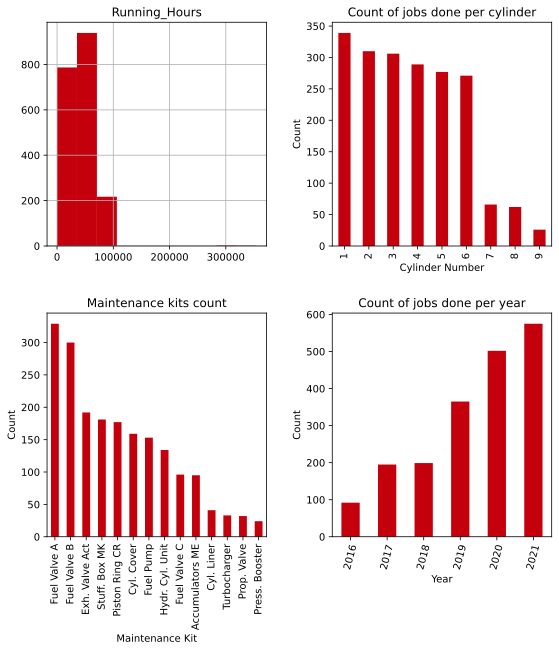

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2)

df.hist('Running_Hours', ax=axes[0,0], color = [(0.77,0,0.05)])
#df['VESSEL_NAME'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[0,0])
df['Cylinder_Number'].value_counts(sort=True).loc[['1', '2', '3','4', '5', '6','7', '8', '9']].plot(kind='bar', title = 'Count of jobs done per cylinder', xlabel='Cylinder Number', ylabel='Count', rot=90, ax=axes[0,1], color = [(0.77,0,0.05)])
df['Maintenance_Kit'].value_counts().plot(kind='bar',title = 'Maintenance kits count', xlabel='Maintenance Kit', ylabel='Count', rot=90, ax=axes[1,0], color = [(0.77,0,0.05)])
df['maintainance_year'].value_counts(sort=False).loc[[2016, 2017, 2018,2019, 2020, 2021]].plot(kind='bar', title = 'Count of jobs done per year', xlabel='Year', ylabel='Count', rot=75, ax=axes[1,1], color = [(0.77,0,0.05)])

<AxesSubplot:>

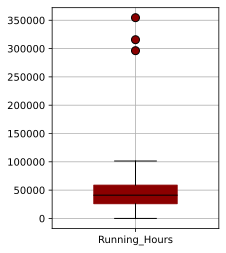

In [17]:
df.boxplot('Running_Hours',  widths = 0.5 , color = dict(boxes='Darkred', whiskers="Black", medians="Black"),  patch_artist=True, flierprops = dict(marker='o', markerfacecolor='darkred', markersize=8, linestyle='none', markeredgecolor='black'), figsize = (3,4))


We see the outliers:

In [18]:
df[df.Running_Hours > 200000]

,VESSEL_NAME,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
1410,Konrad Schulte,2016-11-16,296260.0,Cyl. Cover,4,2016,1
1417,Konrad Schulte,2017-03-06,315650.0,Cyl. Cover,1,2017,1
1418,Konrad Schulte,2017-11-12,354550.0,Cyl. Cover,2,2017,1


In [19]:
# Compare  to the other running hours of the vessel
df[df.VESSEL_NAME == 'Konrad Schulte']

,VESSEL_NAME,Maintenance_Date,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
1410,Konrad Schulte,2016-11-16,296260.0,Cyl. Cover,4,2016,1
1411,Konrad Schulte,2016-11-20,29807.0,Fuel Valve C,2,2016,1
1412,Konrad Schulte,2016-11-20,29807.0,Fuel Valve C,3,2016,1
1413,Konrad Schulte,2016-11-20,29807.0,Fuel Valve C,4,2016,1
1414,Konrad Schulte,2016-11-20,29807.0,Fuel Valve C,5,2016,1
...,...,...,...,...,...,...,...
1504,Konrad Schulte,2021-09-02,53266.0,Fuel Valve A,4,2021,1
1506,Konrad Schulte,2021-09-02,53266.0,Fuel Valve A,6,2021,1
1508,Konrad Schulte,2021-10-21,53760.0,Fuel Valve B,3,2021,1
1509,Konrad Schulte,2021-10-21,53760.0,Fuel Valve C,3,2021,1


Seems they are typos, we drop them

In [20]:
df = df[df['Running_Hours'] <= 200000]

   # 3. DATA PRE-PROCESSING

In [21]:
### 1. ADD ROWS WITH ALL THE POSSIBLE MAINTENANE TYPES FOR EACH CYLINDER FOR EACH YEAR
df = df.complete('VESSEL_NAME', 'Maintenance_Kit', 'Cylinder_Number', 'maintainance_year').fillna(0, downcast='infer')
# Sort the data to have better view
df = df.sort_values(['VESSEL_NAME', 'Cylinder_Number', 'maintainance_year'],
             ascending = [True, True, True])

df = df.reset_index(drop=True)

In [22]:
### 2. THE CREATED ROWS EXCEED THE CORRECT AMOUNT OF ENGINES/CYLIDERS, WE HAVE TO DELETE THEM MANULLY
df = df.astype({"Cylinder_Number": int})
df = df[(df.VESSEL_NAME == 'Aqua Bonanza') & (df.Cylinder_Number <= 6) | 
        (df.VESSEL_NAME == 'Central') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Clamor Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Clover') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Donata Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Dorothea Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Hans Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Hedwig Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Hyde') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Jasper Dream') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Key Sonority') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Konrad Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'LILA II') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Largo Mariner') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'London Courage') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'MSC Agadir') & (df.Cylinder_Number <= 9) |
        (df.VESSEL_NAME == 'MSC Antigua') & (df.Cylinder_Number <= 9) |
        (df.VESSEL_NAME == 'Margarete Schulte') & (df.Cylinder_Number <= 8) |
        (df.VESSEL_NAME == 'Moritz Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'PPS Luck') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'PPS Salmon') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Thalea Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Thekla Schulte') & (df.Cylinder_Number <= 5) |
        (df.VESSEL_NAME == 'Theresa Schulte') & (df.Cylinder_Number <= 5) |
        (df.VESSEL_NAME == 'United Crown') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Weser Stahl') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Zita Schulte') & (df.Cylinder_Number <= 6) |
        (df.VESSEL_NAME == 'Zoe Schulte') & (df.Cylinder_Number <= 6) ]


In [23]:
### 3. CREATE COLUMN WITH AVG RUNNING HOURS
# WE ADD THE RUNNING HOUR INSTANCES PER VESSEL, PER YEAR AND DIVIDE BY THEIR NUMBER
df['Running_Hours'] = df.replace(0, np.nan).groupby(['VESSEL_NAME', 'maintainance_year'])['Running_Hours'].transform('mean') 

df['Running_Hours'].isna().sum()


### 4. FILL NA VALUES WITH AVG OF PREVIOUS AND NEXT
# rearrange the dataframe
df = df.sort_values(['VESSEL_NAME', 'maintainance_year'],
              ascending = [True, True])



# fill na in running hours with the mean of previous-next years, per vessel
df = (df.assign(ffill = df.groupby('VESSEL_NAME').Running_Hours.ffill(),
                 bfill = df.groupby('VESSEL_NAME').Running_Hours.bfill(),
                 both  = df.groupby('VESSEL_NAME').Running_Hours.ffill().add(df.Running_Hours.bfill()),
                 fin = df.groupby('VESSEL_NAME').Running_Hours.ffill().add(df.Running_Hours.bfill()).div(2)))
df['Running_Hours'] = df['Running_Hours'].fillna(df['fin'])



#  for the vessels that still don't have, we apply the running hours from the next year 
df.loc[df['maintainance_year'] == 2016 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2016,'Running_Hours'].fillna(value = (df['bfill']))
df.loc[df['maintainance_year'] == 2017 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2017,'Running_Hours'].fillna(value = df['bfill'])
df.loc[df['maintainance_year'] == 2018 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2018,'Running_Hours'].fillna(value = df['bfill'])
df.loc[df['maintainance_year'] == 2019 ,'Running_Hours'] = df.loc[df['maintainance_year'] == 2019,'Running_Hours'].fillna(value = df['bfill'])

In [24]:
### 5. DROP NOT NEEDED COLUMNS
df = df.drop(columns=['ffill', 'bfill', 'both', 'fin', 'Maintenance_Date'])
df

,VESSEL_NAME,Running_Hours,Maintenance_Kit,Cylinder_Number,maintainance_year,done
0,Aqua Bonanza,47193.0,Fuel Valve B,1,2016,0
1,Aqua Bonanza,47193.0,Cyl. Cover,1,2016,0
2,Aqua Bonanza,47193.0,Exh. Valve Act,1,2016,0
3,Aqua Bonanza,47193.0,Fuel Valve A,1,2016,0
4,Aqua Bonanza,47193.0,Fuel Pump,1,2016,0
...,...,...,...,...,...,...
23573,Zoe Schulte,24016.0,Hydr. Cyl. Unit,6,2022,0
23574,Zoe Schulte,24016.0,Press. Booster,6,2022,0
23575,Zoe Schulte,24016.0,Fuel Valve C,6,2022,0
23576,Zoe Schulte,24016.0,Prop. Valve,6,2022,0


In this step, the dataset is filled with the combination of all the maintenace types that have not occurred in every year, in every cylinder that exists in any engine. The created rows have all zero running hours. They are filled with the average running hours of the current year of the specific vessel, from the existing observations. For the years that have no existing observations in the given vessel, the column is filled with the mean of the years before and after that. Finally, if it is a year that does not have a previous or consequent one (for example 2022), it is assigned with the running hours value of the one before or after (which of the two, exists)

In [25]:
# Save progress 
df1 = df.copy()

In [26]:
#The data contains too few values for year 2022, it might confuse the models, we remove it
df = df[df['maintainance_year'] < 2022]  

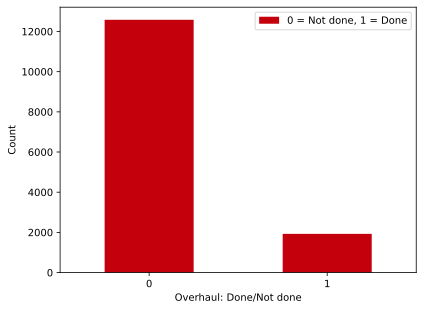

In [27]:
fig, ax = plt.subplots()
df['done'].value_counts().plot(kind='bar', xlabel='Overhaul: Done/Not done', ylabel='Count', rot=0, color = [(0.77,0,0.05)])
plt.legend(['0 = Not done, 1 = Done'])

In [28]:
df['done'].value_counts()

0    12581
1     1925
Name: done, dtype: int64

The data is imbalanced, we should takke it under consideretion when deciding the metrics we are going to use

#### ONE HOT ENCODING

In [29]:
#df=df1.copy()
# change data types
df = df.astype({"Cylinder_Number": object, "maintainance_year": object})



### 1. ONE-OUT-OF K ENCODING
df = pd.get_dummies(df, prefix = '', prefix_sep='')


### 2. SPLIT AND SHUFFLE DATA (25% as test set)
test_proportion = 0.25;
data_train, data_test = train_test_split(df,test_size=test_proportion, random_state=2, shuffle=True);
X_train = data_train.drop('done', axis=1)
X_test = data_test.drop('done', axis=1)
y_train = data_train['done']
y_test = data_test['done']


### 3. OFFSET
# not needed

### 4. STANDARDIZE TEST/TRAIN SETS (only continuous)
X_train['Running_Hours'] = StandardScaler().fit_transform(np.array(X_train['Running_Hours']).reshape(-1,1))
X_test['Running_Hours'] = StandardScaler().fit_transform(np.array(X_test['Running_Hours']).reshape(-1,1))


### 5. RESET INDEX
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

The pre-process is done, see notebook 2_models_LLE_weights.ipynb